In [1]:
import requests
import pathlib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
import seaborn as sns
import plotly.express as pex
from uk_covid19 import Cov19API

### Download the data from gov.uk

In [2]:
cases_path = pathlib.Path("data", "coronavirus-cases_latest.csv")
death_path = pathlib.Path("data", "coronavirus-deaths_latest.csv")
# Remove existing files
for p in [cases_path, death_path]:
    if p.exists():
        p.unlink()

In [3]:
regions = [
    'areaType=region',
]
cases_and_deaths = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "newCasesBySpecimenDate": "newCasesBySpecimenDate",
    "cumCasesBySpecimenDate": "cumCasesBySpecimenDate",
    "cumCasesBySpecimenDateRate": "cumCasesBySpecimenDateRate",
    "newDeaths28DaysByDeathDate": "newDeaths28DaysByDeathDate",
    "cumDeaths28DaysByDeathDate": "cumDeaths28DaysByDeathDate"
}
api = Cov19API(filters=regions, structure=cases_and_deaths)
data = api.get_csv()
with cases_path.open("wt") as p:
    p.write(data)

### Import and reformat the data

Use a 5-day moving average to make general patterns clearer

In [4]:
covid_data = pd.read_csv(cases_path)
covid_data["date"] = pd.to_datetime(covid_data["date"])

In [5]:
covid_data.head()

date    areaName   areaCode  newCasesBySpecimenDate  \
0 2021-06-13  North East  E12000001                     185   
1 2021-06-12  North East  E12000001                     329   
2 2021-06-11  North East  E12000001                     387   
3 2021-06-10  North East  E12000001                     391   
4 2021-06-09  North East  E12000001                     365   

   cumCasesBySpecimenDate  cumCasesBySpecimenDateRate  \
0                  198910                      7450.0   
1                  198725                      7443.0   
2                  198396                      7430.7   
3                  198009                      7416.2   
4                  197618                      7401.6   

   newDeaths28DaysByDeathDate  cumDeaths28DaysByDeathDate  
0                         NaN                         NaN  
1                         0.0                      5977.0  
2                         0.0                      5977.0  
3                         1.0                      5977.0  
4                         0.0                      5976.0

In [6]:
n_days=5

In [7]:
region_data = (covid_data
 .sort_values(by=["date"])
     .set_index(["date"])
 .groupby(["areaName"])
     ["newCasesBySpecimenDate"]
 .rolling(n_days)
 .mean()
 .reset_index()
 .rename(columns={
      "newCasesBySpecimenDate" : f"Daily lab-confirmed cases ({n_days} day average)"
  })
  .merge(covid_data)
)
region_data = region_data[~ pd.isna(region_data[f"Daily lab-confirmed cases ({n_days} day average)"])]

In [8]:
region_deaths = (covid_data
 .sort_values(by=["date"])
     .set_index(["date"])
 .groupby(["areaName"])
     ["newDeaths28DaysByDeathDate"]
 .rolling(n_days)
 .mean()
 .reset_index()
 .rename(columns={
      "newDeaths28DaysByDeathDate" : f"New deaths ({n_days} day average)"
  })
  .merge(covid_data)
)
region_deaths = region_deaths[~ pd.isna(region_deaths[f"New deaths ({n_days} day average)"])]

In [9]:
region_rates = (covid_data
 .rename(columns={
      "cumCasesBySpecimenDateRate" : f"Cumulative lab-confirmed cases per 100k population"
  })
  .merge(covid_data)
)

# Plot cases and deaths over time by region

In [10]:
%matplotlib widget
f, axes = plt.subplots(1, 3)
p = sns.lineplot(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="date", 
             hue="areaName", 
             data=region_data, 
#              sort=False,
                 ax=axes[0])
# Define the date format
date_form = DateFormatter("%m-%d")
axes[0].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

plt.show()
p2 = sns.lineplot(y=f"New deaths ({n_days} day average)",
                  x="date", 
                  hue="areaName", 
                  data=region_deaths, 
#                   sort=False,
                  ax=axes[1])

# Define the date format
date_form = DateFormatter("%m-%d")
axes[1].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

p = sns.lineplot(y="Cumulative lab-confirmed cases per 100k population",
             x="date", 
             hue="areaName", 
             data=region_rates, 
                 ax=axes[2])
# Define the date format
date_form = DateFormatter("%m-%d")
axes[2].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[2].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Deaths by date and region

Deaths are recorded within 28 days.

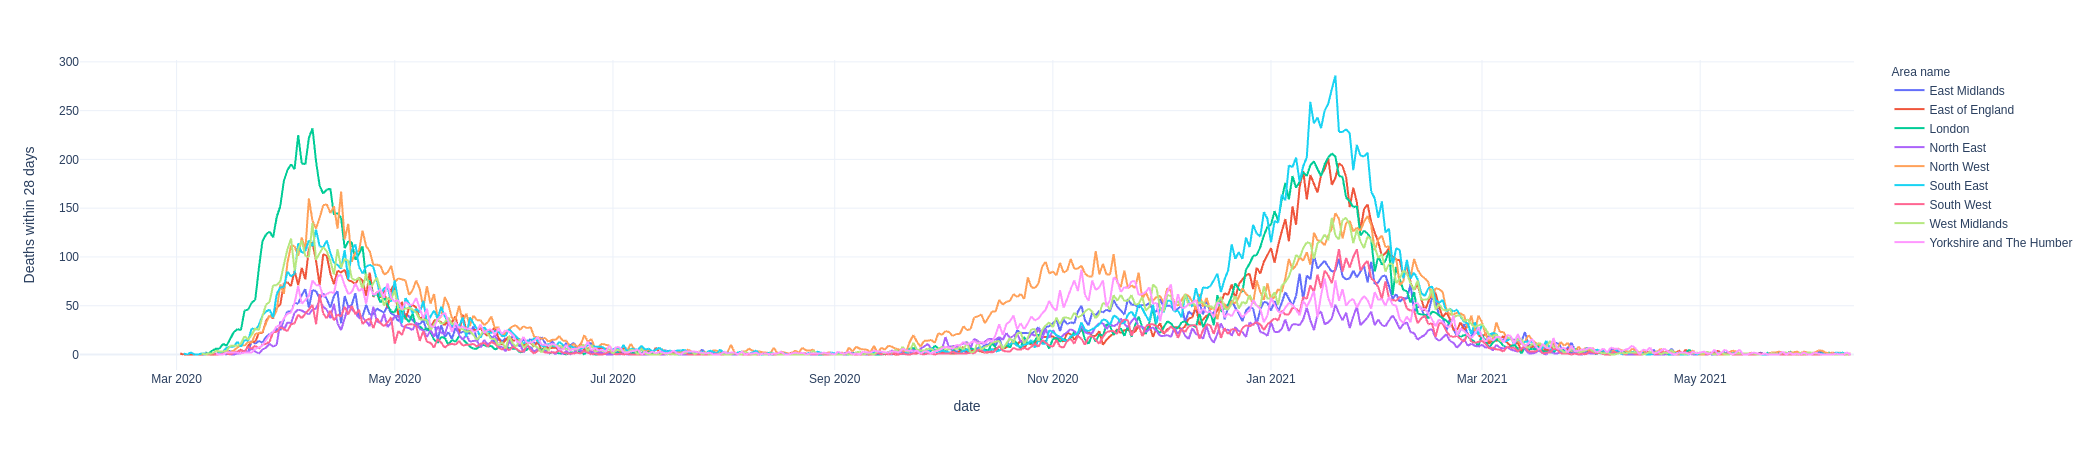

In [11]:
p = pex.line(x="date",
             y="Deaths within 28 days", 
             color="Area name", data_frame=region_data.rename(columns={"newDeaths28DaysByDeathDate" : "Deaths within 28 days", "areaName" : "Area name"}),
            template="plotly_white")
p

In [12]:
region_deaths

areaName       date  New deaths (5 day average)  \
15               East Midlands 2020-03-07                         0.2   
16               East Midlands 2020-03-08                         0.0   
17               East Midlands 2020-03-09                         0.0   
18               East Midlands 2020-03-10                         0.0   
19               East Midlands 2020-03-11                         0.0   
...                        ...        ...                         ...   
4317  Yorkshire and The Humber 2021-06-08                         0.2   
4318  Yorkshire and The Humber 2021-06-09                         0.2   
4319  Yorkshire and The Humber 2021-06-10                         0.2   
4320  Yorkshire and The Humber 2021-06-11                         0.6   
4321  Yorkshire and The Humber 2021-06-12                         0.6   

       areaCode  newCasesBySpecimenDate  cumCasesBySpecimenDate  \
15    E12000004                       5                      31   
16    E12000004                       1                      32   
17    E12000004                      10                      42   
18    E12000004                      12                      54   
19    E12000004                      25                      79   
...         ...                     ...                     ...   
4317  E12000003                     690                  407320   
4318  E12000003                     730                  408050   
4319  E12000003                     666                  408716   
4320  E12000003                     641                  409357   
4321  E12000003                     508                  409865   

      cumCasesBySpecimenDateRate  newDeaths28DaysByDeathDate  \
15                           0.6                         0.0   
16                           0.7                         0.0   
17                           0.9                         0.0   
18                           1.1                         0.0   
19                           1.6                         0.0   
...                          ...                         ...   
4317                      7401.8                         1.0   
4318                      7415.1                         0.0   
4319                      7427.2                         0.0   
4320                      7438.8                         2.0   
4321                      7448.1                         0.0   

      cumDeaths28DaysByDeathDate  
15                           1.0  
16                           1.0  
17                           1.0  
18                           1.0  
19                           1.0  
...                          ...  
4317                     11014.0  
4318                     11014.0  
4319                     11014.0  
4320                     11016.0  
4321                     11016.0  

[4125 rows x 9 columns]

# Cumulative vs new cases

We plot on a log-log scale so that the drop off is more apparent

In [13]:
%matplotlib widget
p = sns.lineplot(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="Cumulative lab-confirmed cases", 
             hue="Area name", 
             data=region_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "areaName" : "Area name"}), 
             sort=False)
p.set_yscale("log")
p.set_xscale("log")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Interactive version of the same graph using plotly

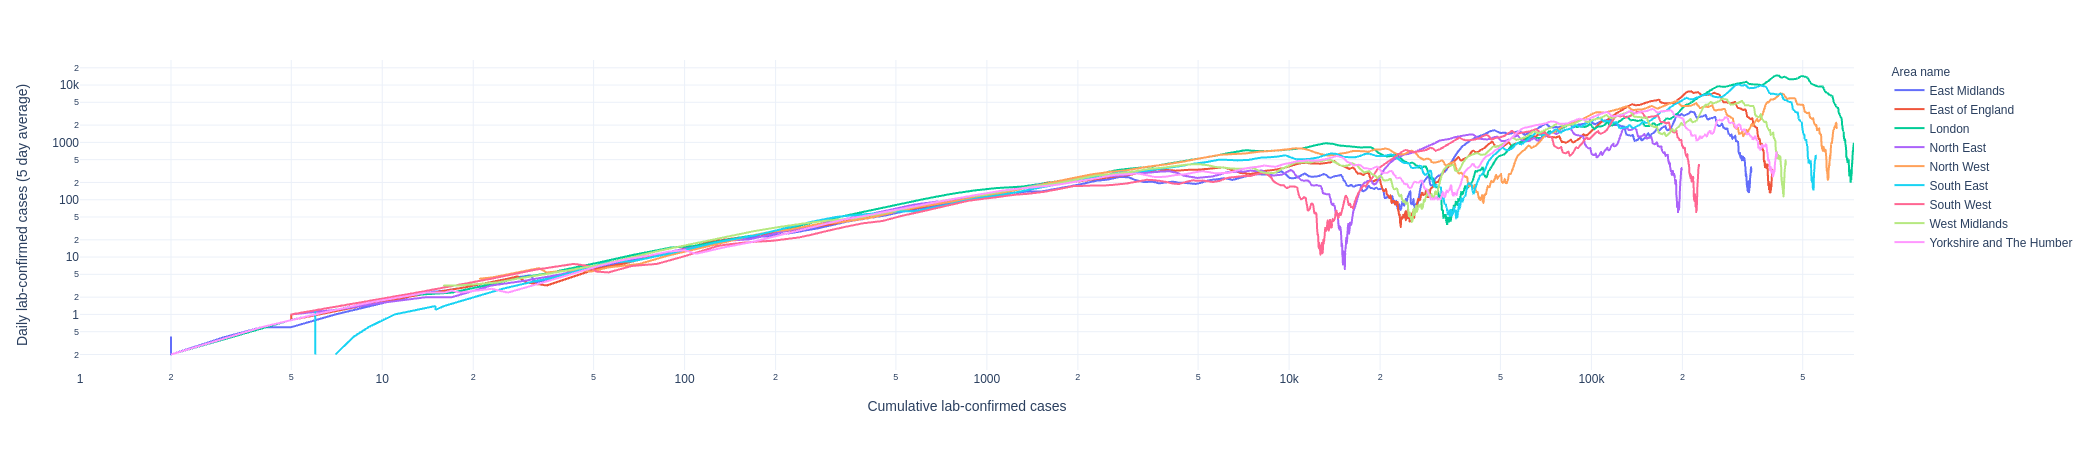

In [14]:
p = pex.line(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="Cumulative lab-confirmed cases", 
             color="Area name", data_frame=region_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "areaName" : "Area name"}),
            template="plotly_white", log_x=True, log_y=True)
p

# Cumulative vs new deaths

In [15]:
%matplotlib widget
p = sns.lineplot(y=f"New deaths ({n_days} day average)",
             x="Cumulative deaths", 
             hue="Area name", 
             data=region_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "areaName" : "Area name"}), 
             sort=False)
p.set_yscale("log")
p.set_xscale("log")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

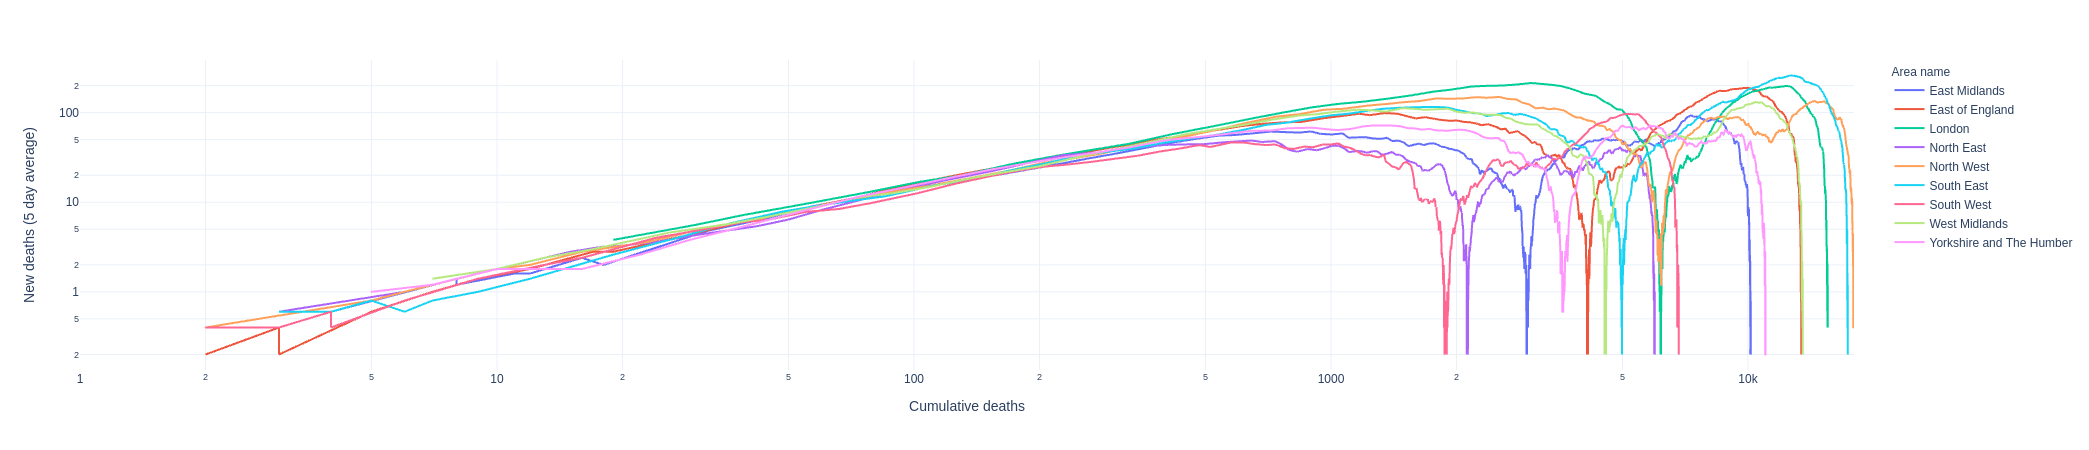

In [16]:
fig = pex.line(y=f"New deaths ({n_days} day average)",
             x="Cumulative deaths", 
             color="Area name", 
             data_frame=region_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "areaName" : "Area name"}),
             template="plotly_white")
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig

### Plot the country-level data

In [17]:
summary_data = region_data.groupby("date")[["Daily lab-confirmed cases (5 day average)", "newCasesBySpecimenDate", "cumCasesBySpecimenDate", "newDeaths28DaysByDeathDate", "cumDeaths28DaysByDeathDate"]].sum().reset_index()
summary_data = summary_data.melt(id_vars=["date", "cumCasesBySpecimenDate"], value_vars=["Daily lab-confirmed cases (5 day average)", "newCasesBySpecimenDate"])
summary_data["variable"] = summary_data["variable"].apply(lambda x: "5 day average" if x == "Daily lab-confirmed cases (5 day average)" else "daily")

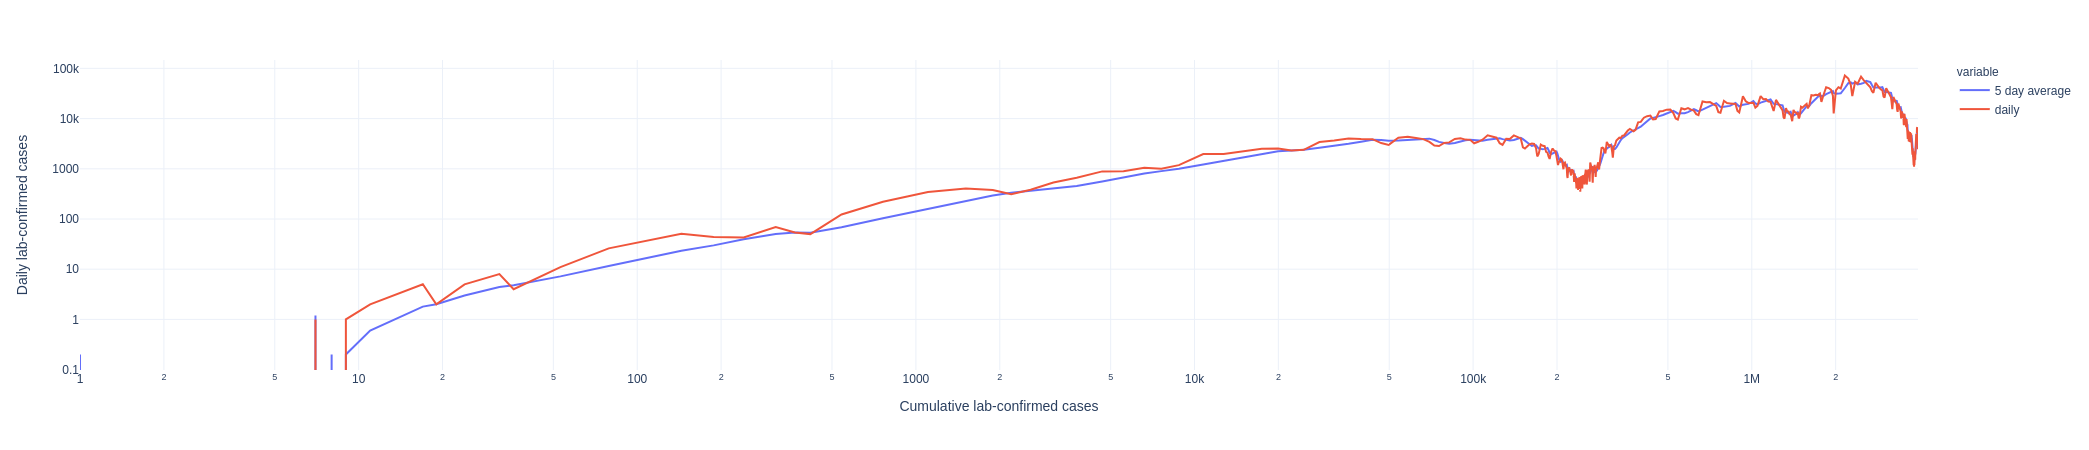

In [18]:
p = pex.line(y=f"Daily lab-confirmed cases",
             x="Cumulative lab-confirmed cases", 
             color="variable",
             data_frame=summary_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "value" : "Daily lab-confirmed cases"}),
            template="plotly_white", log_x=True, log_y=True)
p

In [19]:
summary_deaths = region_deaths.groupby("date")[["New deaths (5 day average)", "newCasesBySpecimenDate", "cumCasesBySpecimenDate", "newDeaths28DaysByDeathDate", "cumDeaths28DaysByDeathDate"]].sum().reset_index()
summary_deaths = summary_deaths.melt(id_vars=["date", "cumDeaths28DaysByDeathDate"], value_vars=["New deaths (5 day average)", "newDeaths28DaysByDeathDate"])
summary_deaths["variable"] = summary_deaths["variable"].apply(lambda x: "5 day average" if x == "New deaths (5 day average)" else "daily")

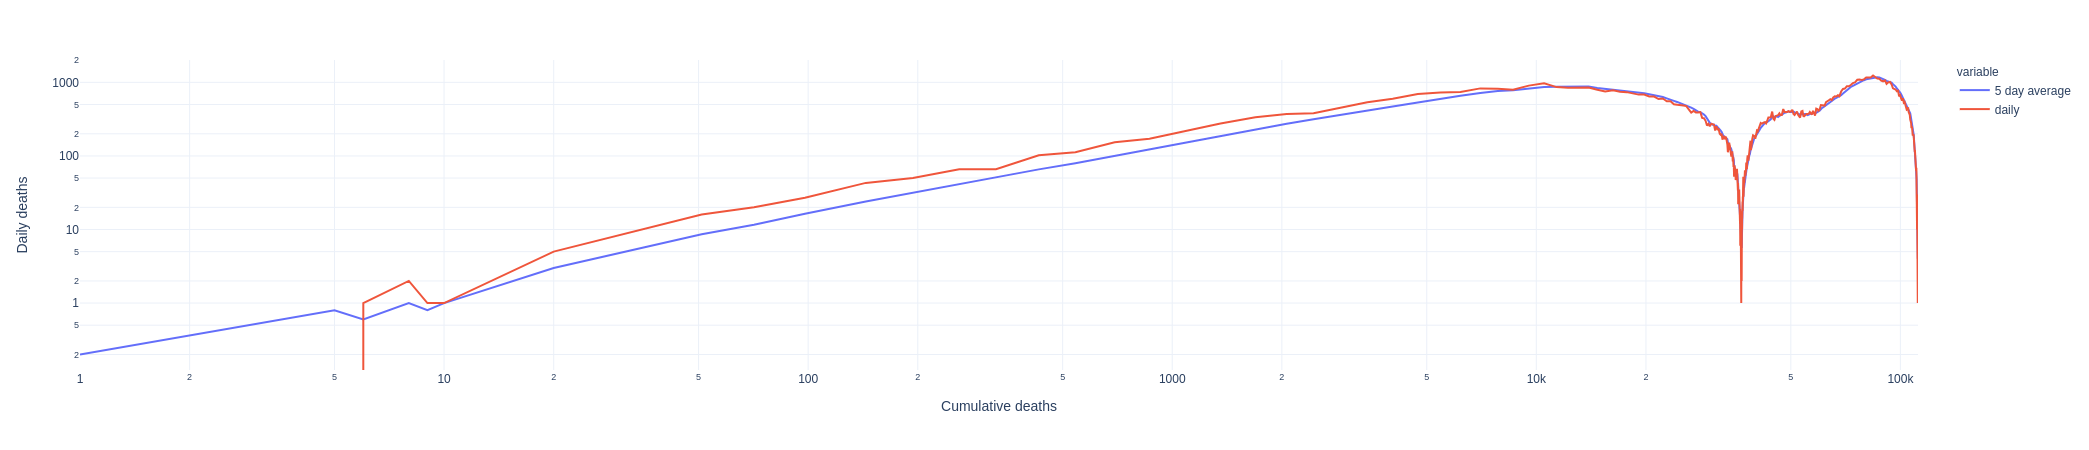

In [20]:
p = pex.line(y=f"Daily deaths",
             x="Cumulative deaths", 
             color="variable",
             data_frame=summary_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "value" : "Daily deaths"}),
            template="plotly_white", log_x=True, log_y=True)
p

### Plot case/death numbers as a proportion of the previous week's values

Use the rolling averages

In [23]:
rolling_week_data = region_data.sort_values(by=["areaName", "date"])

In [27]:
region_data

areaName       date  \
4                East Midlands 2020-02-25   
5                East Midlands 2020-02-26   
6                East Midlands 2020-02-27   
7                East Midlands 2020-02-28   
8                East Midlands 2020-02-29   
...                        ...        ...   
4318  Yorkshire and The Humber 2021-06-09   
4319  Yorkshire and The Humber 2021-06-10   
4320  Yorkshire and The Humber 2021-06-11   
4321  Yorkshire and The Humber 2021-06-12   
4322  Yorkshire and The Humber 2021-06-13   

      Daily lab-confirmed cases (5 day average)   areaCode  \
4                                           0.4  E12000004   
5                                           0.2  E12000004   
6                                           0.2  E12000004   
7                                           0.4  E12000004   
8                                           0.6  E12000004   
...                                         ...        ...   
4318                                      613.6  E12000003   
4319                                      659.2  E12000003   
4320                                      689.8  E12000003   
4321                                      647.0  E12000003   
4322                                      550.2  E12000003   

      newCasesBySpecimenDate  cumCasesBySpecimenDate  \
4                          1                       2   
5                          0                       2   
6                          0                       2   
7                          1                       3   
8                          1                       4   
...                      ...                     ...   
4318                     730                  408050   
4319                     666                  408716   
4320                     641                  409357   
4321                     508                  409865   
4322                     206                  410071   

      cumCasesBySpecimenDateRate  newDeaths28DaysByDeathDate  \
4                            NaN                         NaN   
5                            NaN                         NaN   
6                            NaN                         NaN   
7                            0.1                         NaN   
8                            0.1                         NaN   
...                          ...                         ...   
4318                      7415.1                         0.0   
4319                      7427.2                         0.0   
4320                      7438.8                         2.0   
4321                      7448.1                         0.0   
4322                      7451.8                         NaN   

      cumDeaths28DaysByDeathDate  
4                            NaN  
5                            NaN  
6                            NaN  
7                            NaN  
8                            NaN  
...                          ...  
4318                     11014.0  
4319                     11014.0  
4320                     11016.0  
4321                     11016.0  
4322                         NaN  

[4287 rows x 9 columns]

In [52]:
import numpy as np
rolling_week_data["average_ratio_cases"] = np.NaN
# rolling_week_data["average_ratio_cases"] =
rolling_week_data["average_ratio_cases"].iloc[5:] = rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[5:].values / rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[:-5].values

<ipython-input-52-f1e89c9e287b>:4: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-52-f1e89c9e287b>:4: RuntimeWarning:

invalid value encountered in true_divide

/home/samt/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



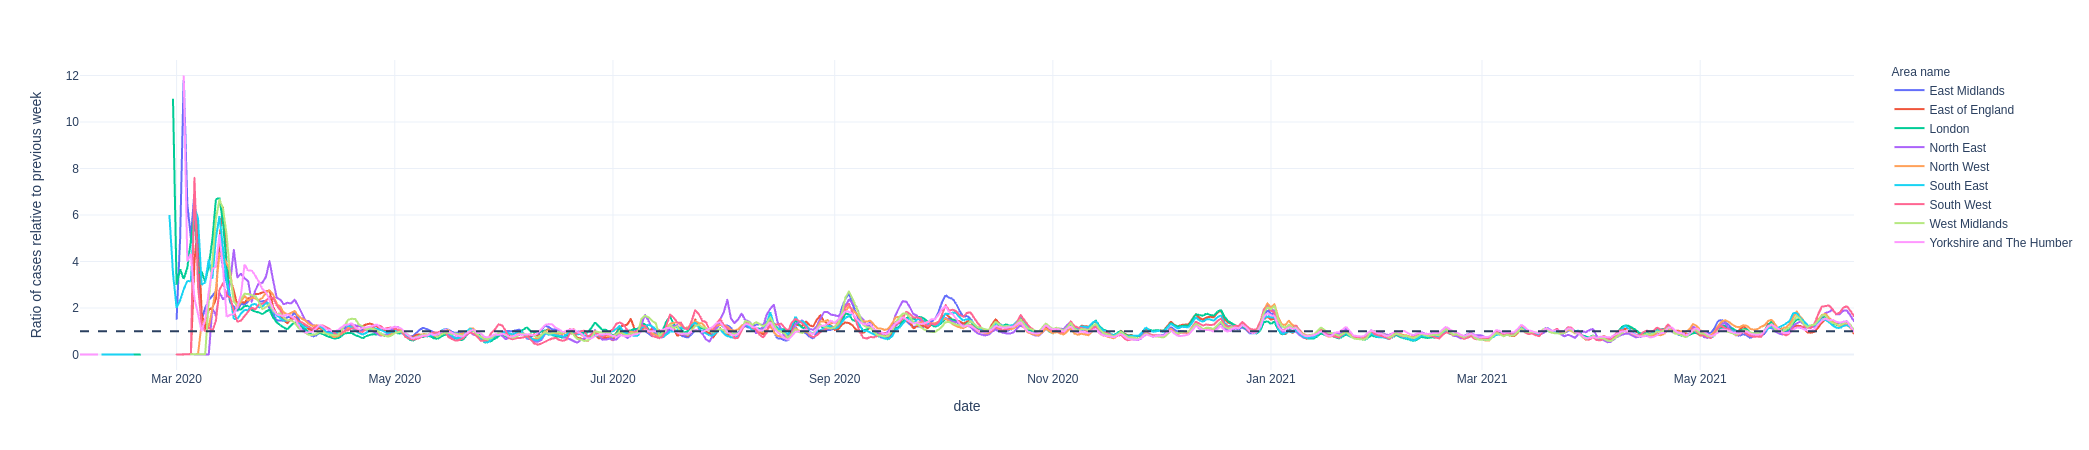

In [56]:
y_axis = "Ratio of cases relative to previous week"
fig = pex.line(y=y_axis,
             x="date", 
             color="Area name", 
             data_frame=rolling_week_data.rename(columns={"average_ratio_cases" : y_axis, "areaName" : "Area name"}),
             template="plotly_white")
fig.add_hline(y=1.0, line_dash="dash")
# fig.update_layout(xaxis_type="log", yaxis_type="log")
fig

#### Group by all regions

In [71]:
daily_col = "Daily lab-confirmed cases (5 day average)"
rolling_week_data_regions = region_data.groupby(["date"])[daily_col].sum().reset_index()

In [72]:
rolling_week_data_regions["average_ratio_cases"] = 0
rolling_week_data_regions["average_ratio_cases"].iloc[5:] = rolling_week_data_regions[daily_col].iloc[5:].values / rolling_week_data_regions[daily_col].iloc[:-5].values

<ipython-input-72-07f7d80eebaa>:2: RuntimeWarning:

divide by zero encountered in true_divide

<ipython-input-72-07f7d80eebaa>:2: RuntimeWarning:

invalid value encountered in true_divide

/home/samt/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
rolling_week_data_regions

date  Daily lab-confirmed cases (5 day average)  average_ratio_cases
0   2020-02-03                                        0.2             0.000000
1   2020-02-04                                        0.0             0.000000
2   2020-02-05                                        0.0             0.000000
3   2020-02-06                                        0.0             0.000000
4   2020-02-07                                        0.0             0.000000
..         ...                                        ...                  ...
492 2021-06-09                                     5580.0             1.281521
493 2021-06-10                                     6094.2             1.350246
494 2021-06-11                                     6414.4             1.402300
495 2021-06-12                                     6081.0             1.240160
496 2021-06-13                                     5301.2             1.020836

[497 rows x 3 columns]

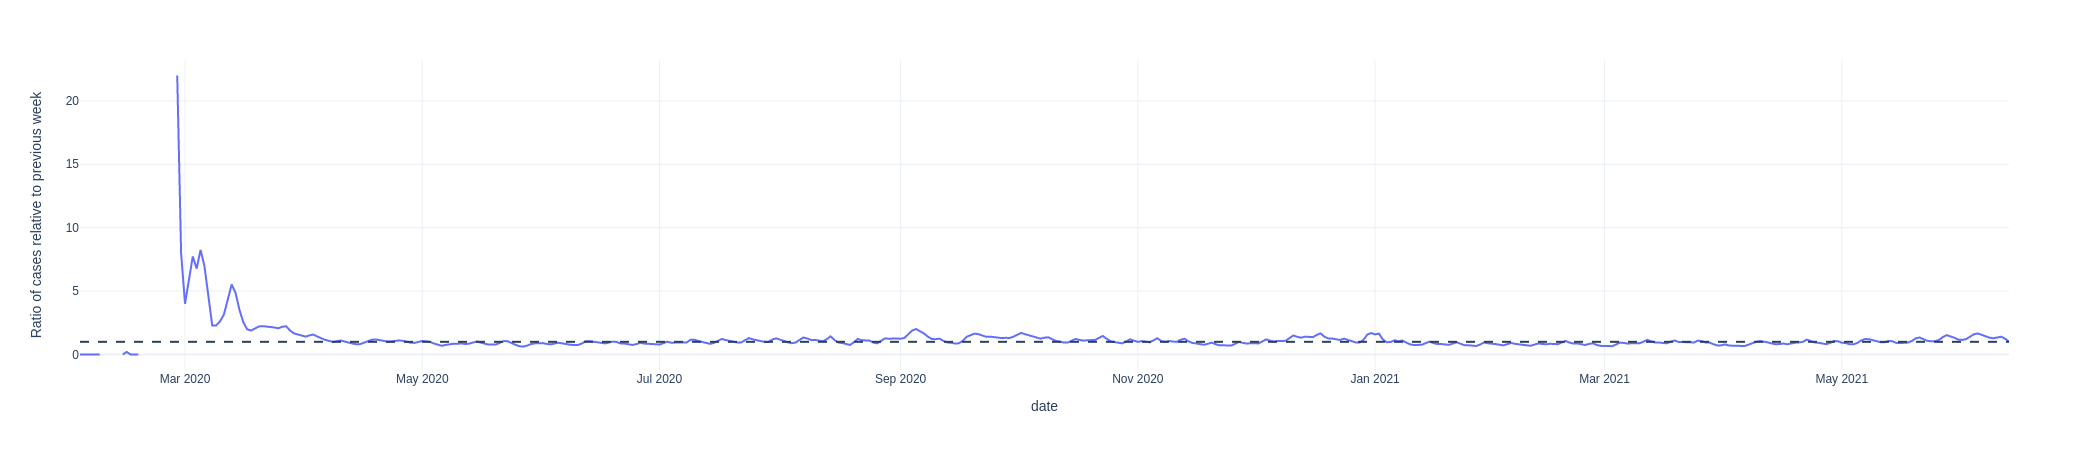

In [77]:
fig = pex.line(y=y_axis,
             x="date", 
             data_frame=rolling_week_data_regions.rename(columns={"average_ratio_cases" : y_axis, "areaName" : "Area name"}),
             template="plotly_white")
fig.add_hline(y=1.0, line_dash="dash")
# fig.update_layout(xaxis_type="log", yaxis_type="log")
fig

In [35]:
rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[0:-1]

4         0.4
5         0.2
6         0.2
7         0.4
8         0.6
        ...  
4317    569.6
4318    613.6
4319    659.2
4320    689.8
4321    647.0
Name: Daily lab-confirmed cases (5 day average), Length: 4286, dtype: float64

In [36]:
rolling_week_data["Daily lab-confirmed cases (5 day average)"].iloc[1:].values

array([2.000e-01, 2.000e-01, 4.000e-01, ..., 6.898e+02, 6.470e+02,
       5.502e+02])